# Multi-Trial Generalizability Experiment Run

## Data Loading and Preprocessing

In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import networkx as nx
import matplotlib.pyplot as plt
from torchinfo import summary
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import scikitplot as skplt
from scipy import stats
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [26]:
def load_and_preprocess_data():
    """Load and preprocess both datasets"""
    
    # Load Dataset 1 (Training data)
    data_path = 'kaggle_dataset_1.csv'
    df = pd.read_csv(data_path)
    
    df_processed = df.copy()
    df_processed['diabetes_binary'] = (df_processed['Diabetes_012'] > 0).astype(int)
    
    age_mapping = {
        1: 21, 2: 27, 3: 32, 4: 37, 5: 42, 6: 47, 7: 52, 
        8: 57, 9: 62, 10: 67, 11: 72, 12: 77, 13: 82
    }
    df_processed['age_numeric'] = df_processed['Age'].map(age_mapping)
    df_processed['bmi'] = df_processed['BMI']
    df_processed['high_bp'] = df_processed['HighBP']
    
    feature_cols = ['age_numeric', 'bmi', 'high_bp']
    target_col = 'diabetes_binary'
    
    X1 = df_processed[feature_cols].values.astype(np.float32)
    y1 = df_processed[target_col].values.astype(np.float32)
    
    # Load Dataset 2 (Test data for generalization)
    data_path_2 = 'kaggle_dataset_2.csv'
    df2 = pd.read_csv(data_path_2)
    
    df2_processed = df2.copy()
    df2_processed['age_numeric'] = df2_processed['Age']
    df2_processed['bmi'] = df2_processed['BMI']
    df2_processed['high_bp'] = ((df2_processed['BloodPressure'] > 80) & 
                               (df2_processed['BloodPressure'] > 0)).astype(int)
    df2_processed['diabetes_binary'] = df2_processed['Outcome']
    
    X2 = df2_processed[feature_cols].values.astype(np.float32)
    y2 = df2_processed[target_col].values.astype(np.float32)
    
    return X1, y1, X2, y2, feature_cols

In [27]:
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def balance_dataset(X, y, random_state=42):
    """Balance dataset by undersampling majority class"""
    from sklearn.utils import resample
    
    indices_class_0 = np.where(y == 0)[0]
    indices_class_1 = np.where(y == 1)[0]
    
    min_class_size = len(indices_class_1)
    
    indices_class_0_downsampled = resample(indices_class_0, 
                                          replace=False, 
                                          n_samples=min_class_size, 
                                          random_state=random_state)
    
    balanced_indices = np.concatenate([indices_class_0_downsampled, indices_class_1])
    np.random.shuffle(balanced_indices)
    
    return X[balanced_indices], y[balanced_indices]


## CausalNet Architecture

In [ ]:
class FeatureEncoder(nn.Module):
    '''
    Simple encoder to transform input features.
    '''
    def __init__(self, input_dims):
        super().__init__()
        self.linear = nn.Linear(input_dims, input_dims)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.relu(self.linear(x))

class StrictCausalLayer(nn.Module):
    '''
    Strict causal layer that learns a sparse adjacency matrix with a maximum number of parents per node.
    '''
    def __init__(self, dim, max_parents=3):
        super().__init__()
        self.dim = dim
        self.max_parents = max_parents
        self.A = nn.Parameter(torch.randn(dim, dim) * 0.01)
        self.register_buffer('mask', torch.tril(torch.ones(dim, dim), diagonal=-1))
        
    def forward(self, z):
        # Sparsity is applied by selecting the top-k parents for each node.
        A_masked = self.A * self.mask
        A_sparse = torch.zeros_like(A_masked)
        for i in range(self.dim):
            col = A_masked[:, i]
            if col.nonzero().numel() > 0:
                _, top_indices = torch.topk(torch.abs(col), 
                                          min(self.max_parents, col.nonzero().numel()))
                A_sparse[top_indices, i] = col[top_indices]
        
        parent_info = z @ A_sparse
        return z + torch.tanh(parent_info)

class Predictor(nn.Module):
    '''
    Simple feedforward neural network for prediction.
    '''
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim//2)
        self.fc2 = nn.Linear(dim//2, 1)
    def forward(self, z):
        h = torch.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h)).squeeze(-1)

class CausalNet(nn.Module):
    '''
    CausalNet definition with strict causal assumptions.
    '''
    def __init__(self, input_dims):
        super().__init__()
        self.encoder = FeatureEncoder(input_dims)
        self.causal_layer = StrictCausalLayer(dim=input_dims)
        self.predictor   = Predictor(dim=input_dims)
    def forward(self, x):
        z = self.encoder(x)
        z_causal = self.causal_layer(z)
        pred = self.predictor(z_causal)
        return pred, z_causal

## StandardNet Architecture

In [29]:
class StandardFeatureEncoder(nn.Module):
    def __init__(self, input_dims, hidden_dims=64):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dims, hidden_dims),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
    
    def forward(self, x):
        return self.network(x)

class StandardPredictor(nn.Module):
    def __init__(self, input_dims, hidden_dims=64):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(hidden_dims, hidden_dims//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dims//2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        return self.network(z).squeeze(-1)

class StandardNet(nn.Module):
    def __init__(self, input_dims, hidden_dims=64):
        super().__init__()
        self.encoder = StandardFeatureEncoder(input_dims, hidden_dims)
        self.predictor = StandardPredictor(input_dims, hidden_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        pred = self.predictor(z)
        return pred

## CasualNet Training

In [30]:
def acyclicity_loss(A):
    """Compute acyclicity constraint loss"""
    # Use a more stable version of the acyclicity constraint
    A_sq = A * A
    trace = torch.trace(torch.matrix_exp(A_sq))
    return trace - A.size(0)

def structural_regularization(A, mask):
    """Compute structural regularization terms"""
    A_masked = A * mask
    sparsity_loss = torch.sum(torch.abs(A_masked))
    magnitude_loss = torch.sum(A_masked ** 2)
    return sparsity_loss + 0.01 * magnitude_loss

def evaluate_training_progress(model, val_loader, device):
    """Evaluate model during training to detect if it's stuck"""
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            pred, _ = model(X_batch)
            predicted = (pred > 0.5).float()
            total_correct += (predicted == y_batch).sum().item()
            total_samples += y_batch.size(0)
        
        accuracy = total_correct / total_samples
    
    model.train()
    return accuracy

def train_causal_model_robust(model, train_loader, val_loader, device, n_epochs=50, lr=1e-3, 
                             min_accuracy=0.55, max_retries=5, patience=10):
    """Train causal network with robust retraining logic"""
    
    best_accuracy = 0
    retry_count = 0
    
    while retry_count < max_retries:
        print(f"Training attempt {retry_count + 1}/{max_retries}")
        
        # Reset model if this is a retry
        if retry_count > 0:
            model.apply(model._init_weights)
            # Slightly modify hyperparameters for diversity
            lr_current = lr * (0.5 + 0.5 * np.random.random())
        else:
            lr_current = lr
        
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr_current, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
                                                       factor=0.5, patience=5)
        
        # Adjust regularization based on retry
        l1_lambda = 1e-4 * (0.5 ** retry_count)  # Reduce regularization on retries
        acyclic_lambda = 1e-2 * (0.5 ** retry_count)
        
        best_val_acc = 0
        patience_counter = 0
        
        for epoch in range(n_epochs):
            model.train()
            total_loss = 0.0
            
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                optimizer.zero_grad()
                pred, _ = model(X_batch)
                
                # Main loss
                bce_loss = criterion(pred, y_batch)
                
                # Regularization terms
                l1_reg = torch.norm(model.causal_layer.A, 1)
                acyc_loss = acyclicity_loss(model.causal_layer.A * model.causal_layer.mask)
                struct_reg = structural_regularization(model.causal_layer.A, model.causal_layer.mask)
                
                total_loss_val = bce_loss + l1_lambda * l1_reg + acyclic_lambda * acyc_loss + struct_reg
                
                total_loss_val.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                total_loss += total_loss_val.item()
            
            # Check validation performance every 5 epochs
            if epoch % 5 == 0:
                val_acc = evaluate_training_progress(model, val_loader, device)
                scheduler.step(val_acc)
                
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                print(f"  Epoch {epoch}, Val Accuracy: {val_acc:.4f}, Best: {best_val_acc:.4f}")
                
                # Early stopping if no improvement
                if patience_counter >= patience:
                    print(f"  Early stopping at epoch {epoch}")
                    break
        
        # Final evaluation
        final_accuracy = evaluate_training_progress(model, val_loader, device)
        print(f"  Final accuracy: {final_accuracy:.4f}")
        
        if final_accuracy >= min_accuracy:
            print(f"  Training successful! Accuracy: {final_accuracy:.4f}")
            return model
        
        best_accuracy = max(best_accuracy, final_accuracy)
        retry_count += 1
        print(f"  Training failed (accuracy: {final_accuracy:.4f} < {min_accuracy}), retrying...")
    
    print(f"Failed to achieve minimum accuracy after {max_retries} attempts. Best: {best_accuracy:.4f}")
    return model

## StandardNet Training

In [31]:
def train_standard_model(model, train_loader, device, n_epochs=30, lr=1e-3):
    """Train standard network"""
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            pred = model(X_batch)
            
            loss = criterion(pred, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        scheduler.step(total_loss / len(train_loader))
    
    return model

## Model Evaluation

In [32]:
def evaluate_model(model, test_loader, device, is_causal=True):
    """Evaluate model and return metrics"""
    model.eval()
    y_preds, y_trues = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            if is_causal:
                pred, _ = model(X_batch)
            else:
                pred = model(X_batch)
            y_preds.append(pred.cpu().numpy())
            y_trues.append(y_batch.numpy())
    
    y_preds = np.concatenate(y_preds)
    y_trues = np.concatenate(y_trues)
    
    auc_score = roc_auc_score(y_trues, y_preds)
    accuracy = accuracy_score(y_trues, (y_preds > 0.5).astype(int))
    
    return auc_score, accuracy

def cross_validate_model(model, X, y, device, n_folds=5, is_causal=True):
    """Perform cross-validation"""
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    cv_scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]
        
        val_loader = DataLoader(DiabetesDataset(X_val_fold, y_val_fold), batch_size=64)
        _, accuracy = evaluate_model(model, val_loader, device, is_causal)
        cv_scores.append(accuracy)
    
    return np.mean(cv_scores), np.std(cv_scores)

## Individual Experiment Definition

In [33]:
def run_single_experiment(trial_num, X1, y1, X2, y2, feature_cols, device):
    """Run a single experiment trial"""
    # Set seed for this trial
    set_seeds(trial_num)
    
    # Split dataset 1 for training
    X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=trial_num)
    
    # Balance training data
    X_train_balanced, y_train_balanced = balance_dataset(X_train, y_train, random_state=trial_num)
    
    # Further split training data to have validation set for causal model
    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
        X_train_balanced, y_train_balanced, test_size=0.2, random_state=trial_num
    )
    
    # Create data loaders
    train_ds = DiabetesDataset(X_train_sub, y_train_sub)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    
    val_ds = DiabetesDataset(X_val_sub, y_val_sub)
    val_loader = DataLoader(val_ds, batch_size=64)
    
    # For standard model, use full balanced training data
    train_ds_full = DiabetesDataset(X_train_balanced, y_train_balanced)
    train_loader_full = DataLoader(train_ds_full, batch_size=64, shuffle=True)
    
    test_ds_1 = DiabetesDataset(X_test, y_test)
    test_loader_1 = DataLoader(test_ds_1, batch_size=64)
    
    test_ds_2 = DiabetesDataset(X2, y2)
    test_loader_2 = DataLoader(test_ds_2, batch_size=64)
    
    # Initialize models
    causal_model = CausalNet(input_dims=len(feature_cols)).to(device)
    standard_model = StandardNet(input_dims=len(feature_cols)).to(device)
    
    # Train both models
    print(f"Trial {trial_num}: Training causal model...")
    causal_model = train_causal_model_robust(causal_model, train_loader, val_loader, device)
    
    print(f"Trial {trial_num}: Training standard model...")
    standard_model = train_standard_model(standard_model, train_loader_full, device)
    
    # Evaluate on test set 1 (same distribution)
    causal_auc_1, causal_acc_1 = evaluate_model(causal_model, test_loader_1, device, is_causal=True)
    standard_auc_1, standard_acc_1 = evaluate_model(standard_model, test_loader_1, device, is_causal=False)
    
    # Evaluate on test set 2 (different distribution - generalization test)
    causal_auc_2, causal_acc_2 = evaluate_model(causal_model, test_loader_2, device, is_causal=True)
    standard_auc_2, standard_acc_2 = evaluate_model(standard_model, test_loader_2, device, is_causal=False)
    
    # Cross-validation on dataset 2
    causal_cv_mean, causal_cv_std = cross_validate_model(causal_model, X2, y2, device, is_causal=True)
    standard_cv_mean, standard_cv_std = cross_validate_model(standard_model, X2, y2, device, is_causal=False)
    
    print(f"Trial {trial_num} completed - Causal AUC: {causal_auc_2:.4f}, Standard AUC: {standard_auc_2:.4f}")
    
    return {
        'trial': trial_num,
        'causal_auc_1': causal_auc_1,
        'causal_acc_1': causal_acc_1,
        'standard_auc_1': standard_auc_1,
        'standard_acc_1': standard_acc_1,
        'causal_auc_2': causal_auc_2,
        'causal_acc_2': causal_acc_2,
        'standard_auc_2': standard_auc_2,
        'standard_acc_2': standard_acc_2,
        'causal_cv_mean': causal_cv_mean,
        'causal_cv_std': causal_cv_std,
        'standard_cv_mean': standard_cv_mean,
        'standard_cv_std': standard_cv_std
    }

## Complete Experiment Definition

In [34]:
def run_full_experiment(n_trials=100):
    """Run the complete experiment with multiple trials"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load data
    X1, y1, X2, y2, feature_cols = load_and_preprocess_data()
    
    print(f"Dataset 1 shape: {X1.shape}")
    print(f"Dataset 2 shape: {X2.shape}")
    print(f"Features: {feature_cols}")
    
    # Run experiments
    results = []
    
    for trial in range(n_trials):
        try:
            result = run_single_experiment(trial, X1, y1, X2, y2, feature_cols, device)
            results.append(result)
        except Exception as e:
            print(f"Error in trial {trial}: {e}")
            continue
    
    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    
    return df_results

## Results Distributions and Analysis

In [35]:
def analyze_results(df_results):
    """Analyze experimental results"""
    print("=" * 80)
    print("EXPERIMENTAL RESULTS SUMMARY")
    print("=" * 80)
    
    # Same distribution performance (Dataset 1)
    print("\n1. SAME DISTRIBUTION PERFORMANCE (Dataset 1)")
    print("-" * 50)
    
    causal_auc_1_mean = df_results['causal_auc_1'].mean()
    causal_auc_1_std = df_results['causal_auc_1'].std()
    standard_auc_1_mean = df_results['standard_auc_1'].mean()
    standard_auc_1_std = df_results['standard_auc_1'].std()
    
    print(f"Causal Network AUC: {causal_auc_1_mean:.4f} ± {causal_auc_1_std:.4f}")
    print(f"Standard Network AUC: {standard_auc_1_mean:.4f} ± {standard_auc_1_std:.4f}")
    
    causal_acc_1_mean = df_results['causal_acc_1'].mean()
    causal_acc_1_std = df_results['causal_acc_1'].std()
    standard_acc_1_mean = df_results['standard_acc_1'].mean()
    standard_acc_1_std = df_results['standard_acc_1'].std()
    
    print(f"Causal Network Accuracy: {causal_acc_1_mean:.4f} ± {causal_acc_1_std:.4f}")
    print(f"Standard Network Accuracy: {standard_acc_1_mean:.4f} ± {standard_acc_1_std:.4f}")
    
    # Generalization performance (Dataset 2)
    print("\n2. GENERALIZATION PERFORMANCE (Dataset 2)")
    print("-" * 50)
    
    causal_auc_2_mean = df_results['causal_auc_2'].mean()
    causal_auc_2_std = df_results['causal_auc_2'].std()
    standard_auc_2_mean = df_results['standard_auc_2'].mean()
    standard_auc_2_std = df_results['standard_auc_2'].std()
    
    print(f"Causal Network AUC: {causal_auc_2_mean:.4f} ± {causal_auc_2_std:.4f}")
    print(f"Standard Network AUC: {standard_auc_2_mean:.4f} ± {standard_auc_2_std:.4f}")
    
    causal_acc_2_mean = df_results['causal_acc_2'].mean()
    causal_acc_2_std = df_results['causal_acc_2'].std()
    standard_acc_2_mean = df_results['standard_acc_2'].mean()
    standard_acc_2_std = df_results['standard_acc_2'].std()
    
    print(f"Causal Network Accuracy: {causal_acc_2_mean:.4f} ± {causal_acc_2_std:.4f}")
    print(f"Standard Network Accuracy: {standard_acc_2_mean:.4f} ± {standard_acc_2_std:.4f}")
    
    # Cross-validation results
    print("\n3. CROSS-VALIDATION RESULTS (Dataset 2)")
    print("-" * 50)
    
    causal_cv_mean = df_results['causal_cv_mean'].mean()
    causal_cv_std = df_results['causal_cv_mean'].std()
    standard_cv_mean = df_results['standard_cv_mean'].mean()
    standard_cv_std = df_results['standard_cv_mean'].std()
    
    print(f"Causal Network CV Accuracy: {causal_cv_mean:.4f} ± {causal_cv_std:.4f}")
    print(f"Standard Network CV Accuracy: {standard_cv_mean:.4f} ± {standard_cv_std:.4f}")
    
    # Statistical significance tests
    print("\n4. STATISTICAL SIGNIFICANCE TESTS")
    print("-" * 50)
    
    # Paired t-tests for generalization performance
    auc_diff = df_results['causal_auc_2'] - df_results['standard_auc_2']
    acc_diff = df_results['causal_acc_2'] - df_results['standard_acc_2']
    cv_diff = df_results['causal_cv_mean'] - df_results['standard_cv_mean']
    
    auc_t_stat, auc_p_value = stats.ttest_1samp(auc_diff, 0)
    acc_t_stat, acc_p_value = stats.ttest_1samp(acc_diff, 0)
    cv_t_stat, cv_p_value = stats.ttest_1samp(cv_diff, 0)
    
    print(f"AUC Difference (Causal - Standard): {auc_diff.mean():.4f} ± {auc_diff.std():.4f}")
    print(f"  t-statistic: {auc_t_stat:.4f}, p-value: {auc_p_value}")
    
    print(f"Accuracy Difference (Causal - Standard): {acc_diff.mean():.4f} ± {acc_diff.std():.4f}")
    print(f"  t-statistic: {acc_t_stat:.4f}, p-value: {acc_p_value}")
    
    print(f"CV Accuracy Difference (Causal - Standard): {cv_diff.mean():.4f} ± {cv_diff.std():.4f}")
    print(f"  t-statistic: {cv_t_stat:.4f}, p-value: {cv_p_value}")
    
    # Effect sizes (Cohen's d)
    auc_effect_size = auc_diff.mean() / auc_diff.std()
    acc_effect_size = acc_diff.mean() / acc_diff.std()
    cv_effect_size = cv_diff.mean() / cv_diff.std()
    
    print(f"\nEffect Sizes (Cohen's d):")
    print(f"  AUC: {auc_effect_size:.4f}")
    print(f"  Accuracy: {acc_effect_size:.4f}")
    print(f"  CV Accuracy: {cv_effect_size:.4f}")
    
    # Win rates
    auc_win_rate = (df_results['causal_auc_2'] > df_results['standard_auc_2']).mean()
    acc_win_rate = (df_results['causal_acc_2'] > df_results['standard_acc_2']).mean()
    cv_win_rate = (df_results['causal_cv_mean'] > df_results['standard_cv_mean']).mean()
    
    print(f"\nWin Rates (Causal > Standard):")
    print(f"  AUC: {auc_win_rate:.2%}")
    print(f"  Accuracy: {acc_win_rate:.2%}")
    print(f"  CV Accuracy: {cv_win_rate:.2%}")

def plot_results(df_results):
    """Create visualizations of results"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # AUC comparison on Dataset 2
    axes[0, 0].boxplot([df_results['causal_auc_2'], df_results['standard_auc_2']], 
                       labels=['Causal', 'Standard'])
    axes[0, 0].set_title('AUC Comparison (Dataset 2)')
    axes[0, 0].set_ylabel('AUC Score')
    axes[0, 0].grid(True, alpha=0.3)
        
    # Accuracy comparison on Dataset 2
    axes[0, 1].boxplot([df_results['causal_acc_2'], df_results['standard_acc_2']], 
                       labels=['Causal', 'Standard'])
    axes[0, 1].set_title('Accuracy Comparison (Dataset 2)')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Cross-validation accuracy comparison
    axes[0, 2].boxplot([df_results['causal_cv_mean'], df_results['standard_cv_mean']], 
                       labels=['Causal', 'Standard'])
    axes[0, 2].set_title('Cross-Validation Accuracy (Dataset 2)')
    axes[0, 2].set_ylabel('CV Accuracy')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Difference distributions
    auc_diff = df_results['causal_auc_2'] - df_results['standard_auc_2']
    acc_diff = df_results['causal_acc_2'] - df_results['standard_acc_2']
    cv_diff = df_results['causal_cv_mean'] - df_results['standard_cv_mean']
    
    axes[1, 0].hist(auc_diff, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].set_title('AUC Difference Distribution\n(Causal - Standard)')
    axes[1, 0].set_xlabel('AUC Difference')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].hist(acc_diff, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 1].set_title('Accuracy Difference Distribution\n(Causal - Standard)')
    axes[1, 1].set_xlabel('Accuracy Difference')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True, alpha=0.3)
    
    axes[1, 2].hist(cv_diff, bins=20, alpha=0.7, color='salmon', edgecolor='black')
    axes[1, 2].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 2].set_title('CV Accuracy Difference Distribution\n(Causal - Standard)')
    axes[1, 2].set_xlabel('CV Accuracy Difference')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Create scatter plot showing trial-by-trial comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # AUC scatter
    axes[0].scatter(df_results['standard_auc_2'], df_results['causal_auc_2'], 
                    alpha=0.6, s=50)
    axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2)
    axes[0].set_xlabel('Standard Network AUC')
    axes[0].set_ylabel('Causal Network AUC')
    axes[0].set_title('Trial-by-Trial AUC Comparison')
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy scatter
    axes[1].scatter(df_results['standard_acc_2'], df_results['causal_acc_2'], 
                    alpha=0.6, s=50, color='orange')
    axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2)
    axes[1].set_xlabel('Standard Network Accuracy')
    axes[1].set_ylabel('Causal Network Accuracy')
    axes[1].set_title('Trial-by-Trial Accuracy Comparison')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Final 100-Trial Experiment Run

Starting 5-trial experiment...
Using device: cpu
Dataset 1 shape: (253680, 3)
Dataset 2 shape: (768, 3)
Features: ['age_numeric', 'bmi', 'high_bp']
Trial 0: Training causal model...
Training attempt 1/5
  Epoch 0, Val Accuracy: 0.6480, Best: 0.6480
  Epoch 5, Val Accuracy: 0.6979, Best: 0.6979
  Epoch 10, Val Accuracy: 0.7038, Best: 0.7038
  Epoch 15, Val Accuracy: 0.6881, Best: 0.7038
  Epoch 20, Val Accuracy: 0.6984, Best: 0.7038
  Epoch 25, Val Accuracy: 0.7017, Best: 0.7038
  Epoch 30, Val Accuracy: 0.7061, Best: 0.7061
  Epoch 35, Val Accuracy: 0.6554, Best: 0.7061
  Epoch 40, Val Accuracy: 0.7029, Best: 0.7061
  Epoch 45, Val Accuracy: 0.6903, Best: 0.7061
  Final accuracy: 0.6911
  Training successful! Accuracy: 0.6911
Trial 0: Training standard model...
Trial 0 completed - Causal AUC: 0.7103, Standard AUC: 0.6976
Trial 1: Training causal model...
Training attempt 1/5
  Epoch 0, Val Accuracy: 0.6550, Best: 0.6550
  Epoch 5, Val Accuracy: 0.6953, Best: 0.6953
  Epoch 10, Val Accu

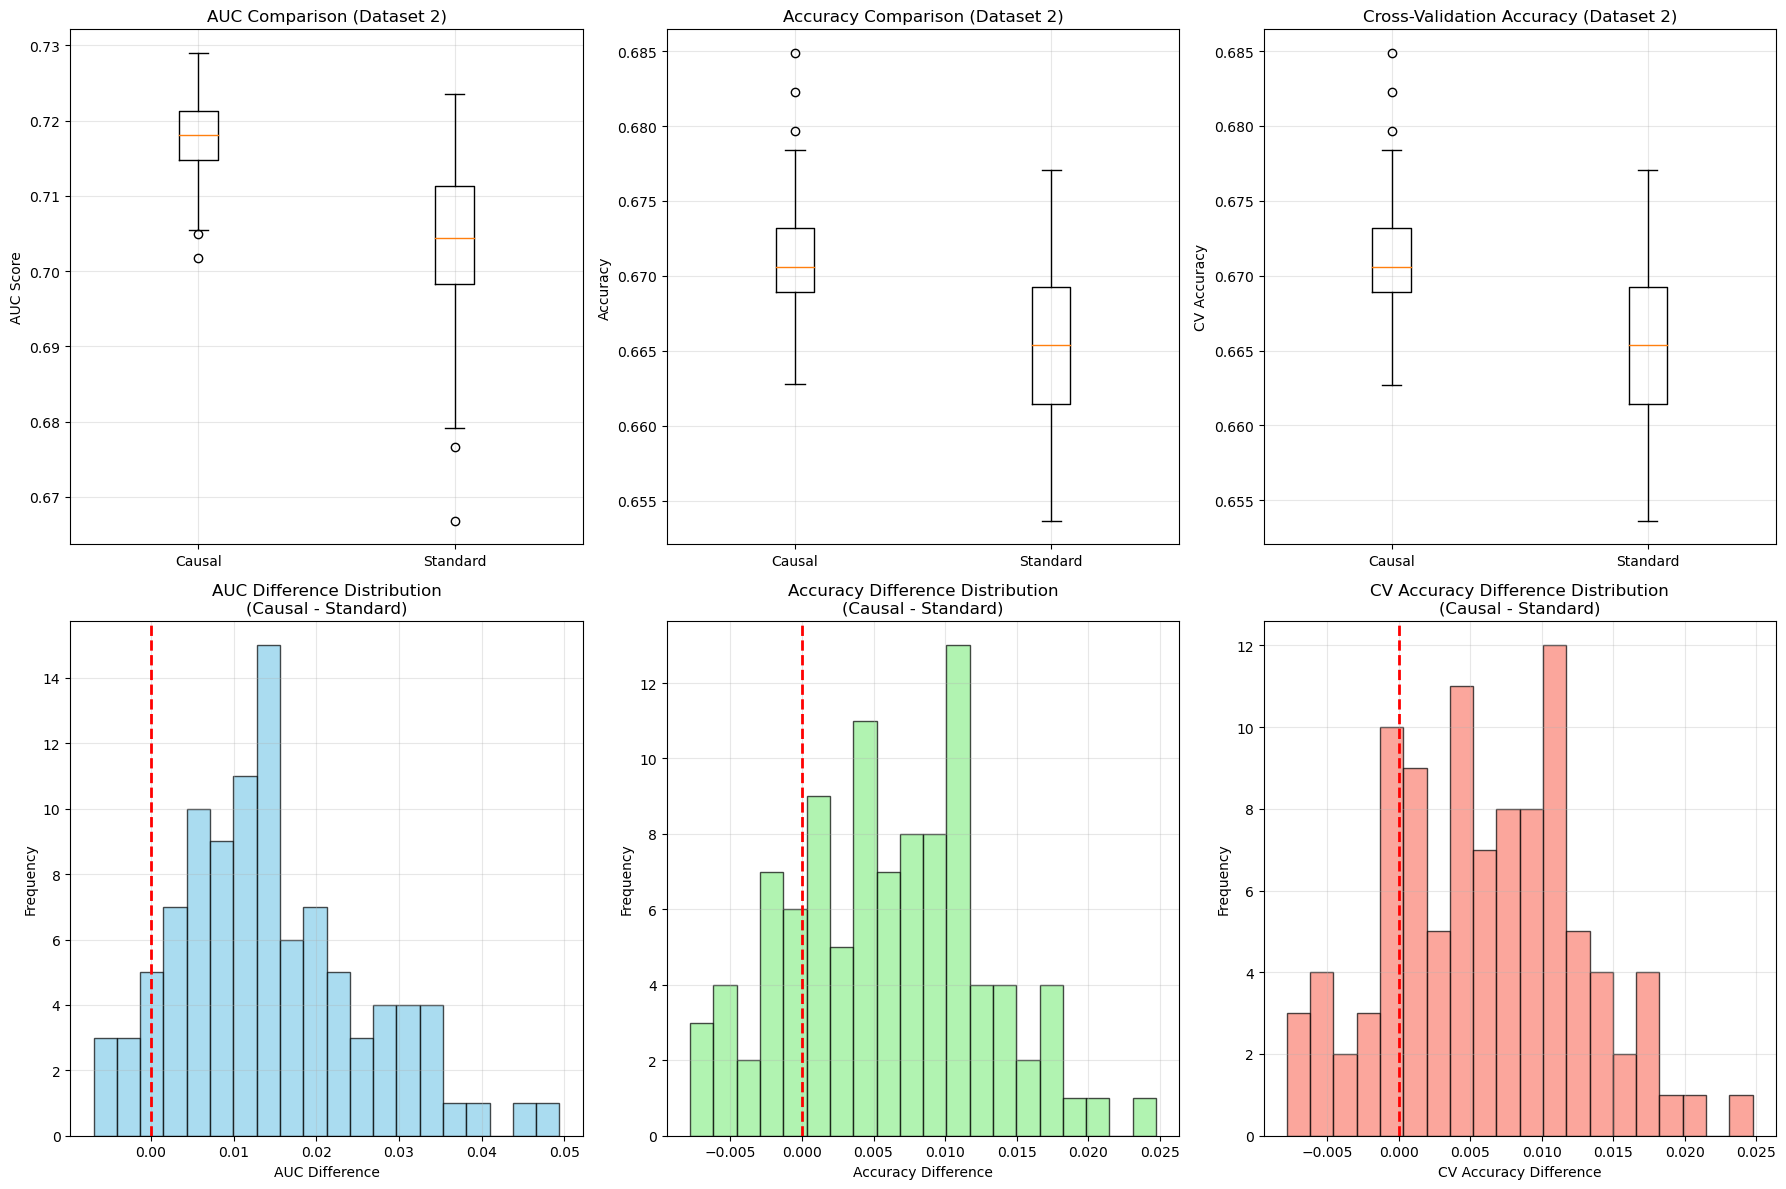

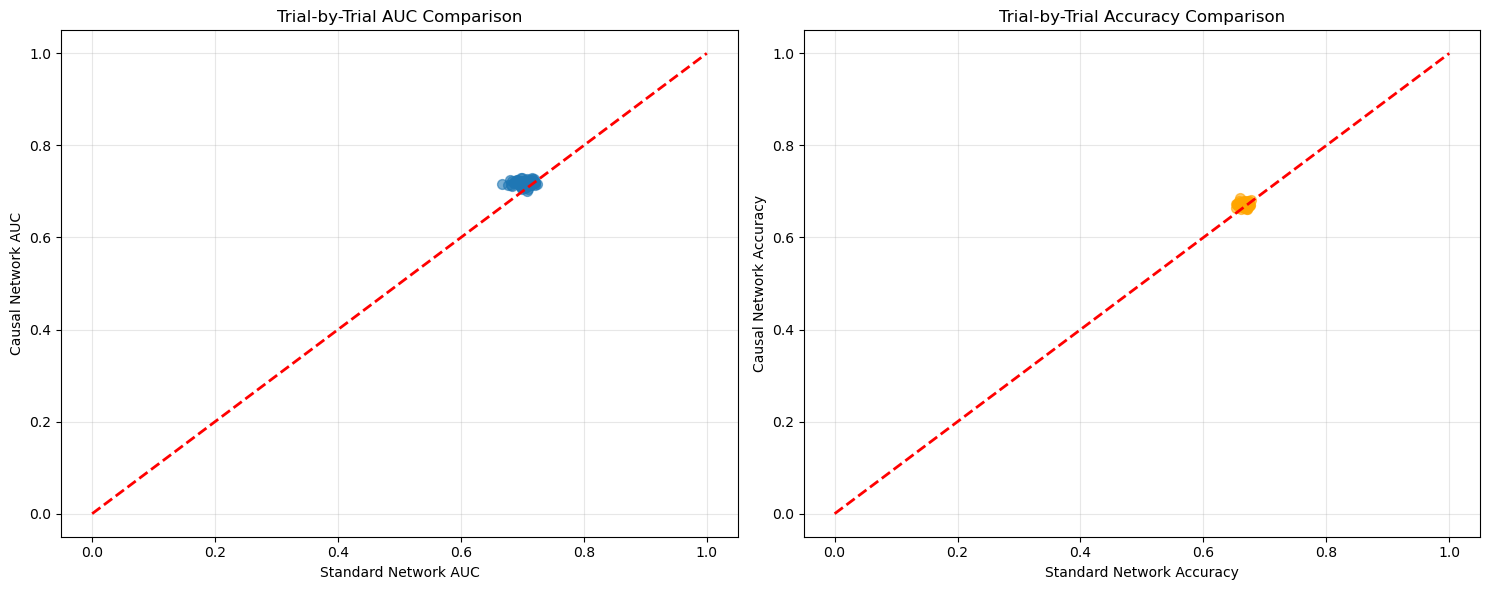


Experiment completed!


In [ ]:
print("Starting 100-trial experiment...")

# Run experiment
df_results = run_full_experiment(n_trials=100)

# Save results
df_results.to_csv('causal_vs_standard_results.csv', index=False)
print(f"Results saved to 'causal_vs_standard_results.csv'")

# Analyze results
analyze_results(df_results)

# Plot results
plot_results(df_results)

print("\nExperiment completed!")